# 📘 Explainable Stylo Workshop Notebook

Welcome to the Colab notebook for the **Explainable Stylo Workshop**.

This notebook helps you:
- Load the [`cl_explainable_stylo`](https://github.com/remolek/Wshop-ExplainableStylo) package from GitHub
- Prepare to work with textual data stored in folders like `example1/`, `example2/`
- Understand how to explore and use the package interactively


In [14]:
# 🔧 Setup: Clone the repository and install the package
import os

# Clone the repo only if it's not already cloned
if not os.path.exists("Wshop-ExplainableStylo"):
    !git clone https://github.com/remolek/Wshop-ExplainableStylo.git
%cd Wshop-ExplainableStylo

/content/Wshop-ExplainableStylo



The main logic of the pipeline is to follow:

<img src="https://github.com/remolek/Wshop-ExplainableStylo/blob/main/notebooks/flowchart2.png?raw=1" width="400">

## 📦 Import the Package

Now that the package is downloaded, you can import its modules and use them in the notebook.
The `base` module below contains the main class which is a wrapper for most of the other functions.


In [15]:
# Import a module from cl_explainable_stylo
from cl_explainable_stylo import base

In [ ]:
help(base)

Help on module cl_explainable_stylo.base in cl_explainable_stylo:

NAME
    cl_explainable_stylo.base - This module defines a base class 'explain_style' providing a pipeline for preprocessing texts (currently by Spacy), extracting their features, classifying them with LGBM, explaining the classifiers with SHAP and visualising the results.

DESCRIPTION
    To initialize the class you need a .json file with metadata of the form, minimally:
    {"experiment_name":"...",
    "labels": ["filename", "class"],
    "files":
            {"filename": ["path_to_file1.txt","path_to_file2.txt"],
            "class": ["file1_class", "file2_class"]}
     }
    
    Author: Jeremi K. Ochab
    Date: August 14, 2023

CLASSES
    builtins.object
        explain_style
    
    class explain_style(builtins.object)
     |  explain_style(metadata_json, manual=True)
     |  
     |  Methods defined here:
     |  
     |  __init__(self, metadata_json, manual=True)
     |      Initialize self.  See help(type(s

In [3]:
import pandas as pd
from pathlib import Path
import re

df = pd.read_csv("train_en.csv")
OUT_DIR = Path("my_corpus_en")
OUT_DIR.mkdir(exist_ok=True)

def sanitize(s):
    return re.sub(r"[^\w]+", "_", str(s))

for _, row in df.iterrows():
    label = sanitize(row["label"])
    doc_id = sanitize(row["id"])
    text = row["text"]

    fname = OUT_DIR / f"{label}__{doc_id}.txt"
    fname.write_text(text, encoding="utf-8")

print("DONE. 转换完成：", OUT_DIR)

DONE. 转换完成： my_corpus_en


## 📁 Example1: two translations

Let's start with a simple example of comparing two translations of Joseph Conrad's *Heart of Darkness* into Polish, by Aniela Zagórska (1930) and Jacek Dukaj (2017).

In [16]:
import os
from glob import glob

# 🔍 Find all folders starting with "example"
# example_dirs = sorted([d for d in os.listdir() if d.startswith("example") and os.path.isdir(d)])
# print(f"Detected folders: {example_dirs}")

# Find and preview all .txt files inside each folder
folder = 'my_corpus_en'
txt_files = sorted(glob(os.path.join(folder, "*.txt")))
print(f"\n📁 {folder} contains {len(txt_files)} .txt files:")
for path in txt_files:
    print(f"  📄 {os.path.basename(path)}")
    with open(path, "r", encoding="utf-8") as f:
        preview = f.read(200).strip().replace("\n", " ")
    print(f"    Preview:\n    {preview[:150]}{'...' if len(preview) > 150 else ''}")


📁 my_corpus_en contains 1026 .txt files:
  📄 0__en_1001.txt
    Preview:
    They are called stockings you queer. Do you actually think I'm a fucking nigger?
  📄 0__en_1004.txt
    Preview:
    Queer is and it isn't, but with queer we have queer studies, queer as a lens in various social and cultural disciplines, LGBTQ etc. We've not quite go...
  📄 0__en_1006.txt
    Preview:
    you go, dude. I have a rainbow avatar in brawlhalla and I sometimes get called trash faggot after a game lol. cracks me up every time.
  📄 0__en_1007.txt
    Preview:
    I love when there’s a general chat and someone just blatantly writes “you fucking faggot” with zero context. I always reply “You rang?”   Chat tends t...
  📄 0__en_1008.txt
    Preview:
    Eeehhhhh... As a Texan from outside of Austin, this state can be incredibly hateful toward homosexuals. I've heard the word "faggot" thrown around in ...
  📄 0__en_101.txt
    Preview:
    &gt;Seriously go Fuck your mom. You are a faggot SJW dick sucking

In [28]:
from pathlib import Path, PurePosixPath
import json
import re

CORPUS_DIR = Path("my_corpus_en")
OUT_JSON = Path("my_init_metadata_en.json")

files, classes, authors = [], [], []

for p in sorted(CORPUS_DIR.glob("*.txt")):
    # 文件名格式：<label>__<id>.txt
    name = p.stem  # e.g., "0__en_1021"

    label = name.split("__")[0]   # 0 或 1
    author = label                # 暂用 label 作为 author（ExplainableStylo 必需字段）

    files.append(str(PurePosixPath(p)))
    classes.append(label)
    authors.append(author)

meta = {
    "experiment_name": "explain_train_en",
    "labels": ["filename", "class", "author"],
    "files": {
        "filename": files,
        "class": classes,
        "author": authors
    },
    "preproc_scheme": {
        "model": "en_core_web_trf"   # 英文模型
    }
}

OUT_JSON.write_text(json.dumps(meta, indent=2), encoding="utf-8")
print("[DONE] metadata 写出到:", OUT_JSON)

[DONE] metadata 写出到: my_init_metadata_en.json


### 📄 Text loading and processing

Before we have prepared a small `.json` file, containing the basic metadata for our first experiment (at this point it might seem a bit redundant).

In [29]:
import json
from IPython.display import JSON, display

# Load the JSON
with open('my_init_metadata_en.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Display an interactive JSON tree (in Jupyter lab only)
display(JSON(data))


<IPython.core.display.JSON object>

With these metadata we will initialize the experiment. All the text, results, etc. will be stored in one variable `exp`.

In [30]:
exp = base.explain_style('my_init_metadata_en.json',manual = True)

Initialisation metadata loaded from my_init_metadata_en.json.
Available text labels ['filename', 'class', 'author'].
Predefined text classes ['0', '1'].
Text preprocessing parameters loaded. Later, you can use load_params_preproc(filename) to set these parameters.
You are in manual mode. The next steps would be to run in sequence '.texts_load()', '.texts_preprocess()', '.texts_subsample()', '.extract_features()', '.classify()', '.explain()', and then any of the '.plot_...()' methods. If you would like to change the parameters provided in metadata or set by default  ('preproc_scheme', 'subsample_scheme', 'feature_scheme', 'cv_scheme', 'classifier_scheme'), please, load them via '.load_parameter_name()' to avoid incosistent file naming and config saving.


Let's follow the instructions and load the text files by calling the method `.texts_load()` on our all-embracing `exp`. After that they will be stored in `exp.texts` (to be exact, these are going to be tuples of text and its metadata).

In [31]:
exp.texts_load()

List of labels used: '['filename', 'class', 'author']'.


0it [00:00, ?it/s]

If you have not run spaCy in this notebook before, it will ask your permission to install a language model. It may take a minute to download and install the model. Afterwards, the text processing will commence.

[⏱️ Session lifespan in GoogleColab might be from idle ~90 min. to ~12 hrs code running. Every time after the session is over and you start the environment again, all the packages and models need to be loaded again too].

In [16]:
!pip install "spacy[transformers]"
!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 795.8/795.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 86.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 2.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab not

In [34]:
exp.texts_preprocess()

Default folder 'explain_explain_train_en/subsamples_none_800' created.
Labels ['filename', 'class', 'author'] will be now accessible in documents via 'document._.label'.
Provided model name for Spacy: 'en_core_web_trf'.
Number of documents provided: 1026.


0it [00:00, ?it/s]

Documents saved as explain_explain_train_en/subsamples_none_800/docs.spacy.
They can be reloaded with '.docs_load(filename)'.
Preprocessing parameters saved as 'explain_explain_train_en/subsamples_none_800/config_preproc_scheme.json'. It can be reloaded with '.load_params_preproc(filename)'.


If you are running the code locally, you will notice some new

*   folders, e.g., `explain_example1/` - referring to the given experiment
*   subfolders, e.g., `subsamples_none_800` - referring to some preprocessing parameters related to segmenting the texts into smaller chunks
*   config files, e.g., `config_*.json` - containing Python dictionaries listing all the settings and parameters (currently the default ones)
*   data files, e.g., `docs.spacy` - texts already processed by spaCy

They are supposed to store for your later reference the processing steps you have taken and allow you reloading intermediate steps of the analysis.

Now, you have your `exp.docs` ready in memory. But let's assume that you are working on your own laptop and want to reload them tomorrow...
```
exp.docs_load(filename = 'docs.spacy')
# This looks for 'docs.spacy' in your experiment's directory 'explain_example1/subsamples_none_800/'
# This is a default name, so you do not need to indicate the filename:
# exp.docs_load()
```

In [35]:
exp.metadata

{'experiment_name': 'explain_train_en',
 'labels': ['filename', 'class', 'author'],
 'files': {'filename': ['my_corpus_en/0__en_1001.txt',
   'my_corpus_en/0__en_1004.txt',
   'my_corpus_en/0__en_1006.txt',
   'my_corpus_en/0__en_1007.txt',
   'my_corpus_en/0__en_1008.txt',
   'my_corpus_en/0__en_101.txt',
   'my_corpus_en/0__en_1010.txt',
   'my_corpus_en/0__en_1011.txt',
   'my_corpus_en/0__en_1012.txt',
   'my_corpus_en/0__en_1014.txt',
   'my_corpus_en/0__en_1016.txt',
   'my_corpus_en/0__en_1017.txt',
   'my_corpus_en/0__en_1019.txt',
   'my_corpus_en/0__en_1020.txt',
   'my_corpus_en/0__en_1021.txt',
   'my_corpus_en/0__en_1022.txt',
   'my_corpus_en/0__en_1023.txt',
   'my_corpus_en/0__en_1024.txt',
   'my_corpus_en/0__en_1028.txt',
   'my_corpus_en/0__en_103.txt',
   'my_corpus_en/0__en_1030.txt',
   'my_corpus_en/0__en_1032.txt',
   'my_corpus_en/0__en_1033.txt',
   'my_corpus_en/0__en_1034.txt',
   'my_corpus_en/0__en_1036.txt',
   'my_corpus_en/0__en_1037.txt',
   'my_corpus

In [36]:
print(f"You've got {len(exp.docs)} texts ready.\n"
f"The first author is {exp.docs[0]._.author}, and the second {exp.docs[1]._.author}.")

You've got 1026 texts ready.
The first author is 0, and the second 0.


This is rather few texts per author. The classifier won't have much to go on with later.

So let's 🪓🪓🪓 these beautiful pieces of literature into smaller chunks to get more samples.

Currently implemented choices of `sample_type` are:
- `'none'` - no chunking
- `'t'` - segments defined by their number of tokens
- `'s'` - segments defined by their number of sentences (as defined by spaCy)
- `'ts'` - segments defined by their number of tokens, but make sure they don't cut sentences in half.

In [37]:
exp.subsample_scheme = {'sample_type': 'none', 'sample_length': 0}
exp.texts_subsample()
print(f"Samples 1-150 are {exp.docs_subsampled[0]._.author}'s, and 151-351 are {exp.docs_subsampled[170]._.author}'s.")

No text subsampling with current setting: 'sample_type = 'none'.
Samples 1-150 are 0's, and 151-351 are 0's.


### 🔬 Feature extraction

This is how our text samples look now:

In [38]:
from IPython.display import display, HTML
sample = exp.docs_subsampled[153]
display(HTML(f"<pre style='white-space:pre-wrap'>{sample}</pre>"))

But spaCy gives you plenty of annotation, e.g.:

In [39]:
print(f"Lemmas: {[token.lemma_ for token in sample[-20:]]}")
print(f"Categories of named entities: {[token.ent_type_ for token in sample[-20:]]}")
print(f"Part-of-speech tags: {[token.pos_ for token in sample[-20:]]}")
print(f"Dependency tags: {[token.dep_ for token in sample[-20:]]}")

Lemmas: ['racist', 'and', 'very', 'anti', 'lgbt', '.', 'the', 'word', 'faggot', 'have', 'be', 'pop', 'up', 'there', 'all', 'week', '.']
Categories of named entities: ['', '', '', '', '', '', '', '', '', '', '', '', '', '', 'DATE', 'DATE', '']
Part-of-speech tags: ['ADJ', 'CCONJ', 'ADV', 'ADJ', 'ADJ', 'PUNCT', 'DET', 'NOUN', 'NOUN', 'AUX', 'AUX', 'VERB', 'ADP', 'ADV', 'DET', 'NOUN', 'PUNCT']
Dependency tags: ['ROOT', 'cc', 'advmod', 'amod', 'conj', 'punct', 'det', 'nsubj', 'appos', 'aux', 'aux', 'ROOT', 'prt', 'advmod', 'det', 'npadvmod', 'punct']


You can utilise many of these as features for the classifier, and later as features that will explain differences between text styles.

A longer list is given below (in the `feature_extraction` module of our package):

In [40]:
from cl_explainable_stylo import feature_extraction
help(feature_extraction.count_features)

Help on function count_features in module cl_explainable_stylo.feature_extraction:

count_features(docs, feature_scheme={'features': [13, 23, 30, 52], 'max_features': 1000, 'n_grams_word': (1, 3), 'n_grams_pos': (1, 3), 'n_grams_dep': (1, 3), 'n_grams_morph': (1, 1), 'min_cull_word': 0.0, 'max_cull_word': 1.0, 'min_cull_d2': 0.0, 'max_cull_d2': 1.0, 'remove_duplicates': True}, verbose=0, tqdm_propagate=False)
    Count the features in the given documents.

    Parameters
    ----------
    docs : spacy.tokens.doc.Doc or spacy.tokens.span.Span or list
        A single `spacy.tokens.doc.Doc` object or `spacy.tokens.span.Span` or a list of such objects representing the documents.
    features : int or list
        A single integer or a list of integers representing the features to count.
    max_features : int, optional
        The maximum number of features to consider (default is 1000).
    n_grams_word : tuple, optional
        The n-gram range for word features (default is (1, 3)).
  

You choose from the above the ones that you consider potentially useful.

The default settings are defined in `exp.default_feature_scheme`,
and the currently used settings are stored in `exp.feature_scheme`, which you can modify.

🥼 Currently, the pipeline is implemented to work with _spaCy_.  If have your own annotations, you have to extract them as features on your own. But you can still use them in later steps.

In [41]:
exp.default_feature_scheme

{'features': [13, 23, 32, 52, 61],
 'max_features': 1000,
 'n_grams_word': (1, 3),
 'n_grams_pos': (1, 3),
 'n_grams_dep': (1, 3),
 'n_grams_morph': (1, 1),
 'min_cull_word': 0.0,
 'max_cull_word': 1.0,
 'min_cull_d2': 0.0,
 'max_cull_d2': 1.0,
 'remove_duplicates': False}

In [42]:
exp.feature_scheme['max_features']=1500
exp.feature_scheme

{'features': [13, 23, 32, 52, 61],
 'max_features': 1500,
 'n_grams_word': (1, 3),
 'n_grams_pos': (1, 3),
 'n_grams_dep': (1, 3),
 'n_grams_morph': (1, 1),
 'min_cull_word': 0.0,
 'max_cull_word': 1.0,
 'min_cull_d2': 0.0,
 'max_cull_d2': 1.0,
 'remove_duplicates': False}

Now, let the machine do some heavy lifting for us:

In [43]:
exp.extract_features(save_to_file=True)

Number of documents provided: 1026.
Features to be extracted: [13, 23, 32, 52, 61].


  0%|          | 0/5 [00:00<?, ?it/s]

-- Extracting non-NER lemmas (replacing named entities with their entity type).
-- Extracting dependency-based non-NER lemma bigrams (including punctuation, excluding numerals, replacing named entities with their entity type).
-- Extracting all parts of speech (no punctuation).
-- Extracting morphology annotations with punctuation (replacing named entities with their entity type).
-- Extracting all named entities.
Default folder 'explain_explain_train_en/subsamples_none_0' created.
Feature extraction parameters saved as 'explain_explain_train_en/subsamples_none_0/config_feature_scheme.json'. It can be reloaded with '.load_params_feature(filename)'.
'.feature_dataframe' saved as 'explain_explain_train_en/subsamples_none_0/features.csv'. It can be reloaded with '.features_load(filename)'.


The table (samples x features) is going to be saved as a `.csv` file, which can later be reloaded with
```
exp.features_load(filename = 'features.csv')
```
Our all-encompassing variable `exp` now contains also that table `exp.feature_dataframe` encoded as a _Pandas_ `DataFrame`.

⚠️ It can grow rather **BIG**, ~100 MB and more, depending on the size of your corpus and the number of features.

⚠️ The folder for storage is named after the subsampling settings: `subsamples_ts_200`. If you make multiple experiments with different subsampling settings, they are going to be stored separately. If you make experiments with different `.feature_scheme` settings, they might overwrite or produce `features_1.csv`, `features_2.csv`, etc. (with corresponding `config_*_1.json`, `config_*_2.json`, ..., files).


In [45]:
exp.feature_dataframe

,128514_13,8220_13,8220 user_13,8230_13,able_13,able to_13,about_13,about how_13,about it_13,about the_13,...,white_61,whole_61,whopping_61,xians_61,year_61,years_61,yesterday_61,york_61,ypu_61,zero_61
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


🥼 If have your own features and they are in the same table format (especially the number of text samples), you can still load them with
```
exp.features_load(filename = 'features.csv')
```
Alternatively, if you have them stored in a variable as _Pandas_ `DataFrame`,
you can simply put it into the `exp` (without unnecessary computing `exp.extract_features()`):
```
exp.feature_dataframe = your_df
```

### 🏋️‍♀️ Training a classifier

Everything's ready to feed the classifier, train it to distinguish between the authors and then explain how it is doing that.

In fact, we are going to train several classifiers on different data subsets to be able to assess reliability of the pipeline.

The standard technique for that is cross-validation. You can simply divide the dataset into *k* equal sized sets of samples, train on *k-1* and test the results on the one that was left out.

![K-fold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_006.png)

If your classes have unequal numbers of samples, stratification might be advisable.

![stratified K-fold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_009.png)

Like before, the default settings are defined in `exp.default_cv_scheme` and `exp.default_classifier_scheme`,
and the currently used settings are stored in `exp.cv_scheme` and `exp.classifier_scheme`, which you can modify.

⚠️ Not all the settings are used for a given `cv_method`.

🥼 The parameters come from the [scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html) package. If you want to make some fancy settings, check their documentation.


In [46]:
exp.cv_scheme

{'cv_method': 'StratifiedKFold',
 'n_repeats': 10,
 'n_splits': 10,
 'shuffle': True,
 'n_groups': 2,
 'p': 2,
 'test_fold': [1, 0, 1, 1, 0],
 'test_size': 0.2,
 'train_size': 0.2,
 'random_state': None,
 'val_fraction': 0.25,
 'scoring': {'acc': {'func': <function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>},
  'f1': {'func': <function sklearn.metrics._classification.fbeta_score(y_true, y_pred, *, beta, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
   'params': {'beta': 1, 'average': 'macro'}}}}

In [47]:
exp.cv_scheme['val_fraction'] = 0. # There's a bug that I need to fix. Here is the current workaround.
exp.cv_scheme['n_repeats'] = 1

In [48]:
exp.classify(save_to_file=True)

Proceeding with 2 classes.
Proceeding with StratifiedKFold cross-validation.


  0%|          | 0/1 [00:00<?, ?it/s]

'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:923, Val:0, Test:103
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:923, Val:0, Test:103
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:923, Val:0, Test:103
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:923, Val:0, Test:103
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:923, Val:0, Test:103
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:923, Val:0, Test:103
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:924, Val:0, Test:102
'val_fraction' setting results in 0.0 validation samples. No nested validation will be performed.
Train:924, Val:0, Test:102


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy [0-1, higher better]: 	0.90 	 Baseline value:  0.91
F1 [0-1, higher better]: 		0.50 	 Baseline value:  0.48
Scores saved as explain_explain_train_en/subsamples_none_0/scores_class-class.pkl.
Classifiers saved as explain_explain_train_en/subsamples_none_0/classifiers_class-class.pkl.
Classifiers saved as booster_*.txt.
Classifier parameters saved as 'explain_explain_train_en/subsamples_none_0/config_classifier_scheme.json'. It can be reloaded with '.load_params_classifier(filename)'.
Cross-validation parameters saved as 'explain_explain_train_en/subsamples_none_0/config_cv_scheme.pkl'. It can be reloaded with '.load_params_cv(filename)'.


Let's check if the classifier is actually able to correctly attribute the samples to the authors (this is the result averaged over cross-validation folds and repetitions):

In [49]:
exp.scores.print_scores()

Accuracy [0-1, higher better]: 	0.90 	 Baseline value:  0.91
F1 [0-1, higher better]: 		0.50 	 Baseline value:  0.48


If you need to scrutinize the classification decision for individual samples for some reason (e.g., find which segments have been classified erroneously)

In [50]:
exp.scores.df_preds
# exp.scores.df_preds[exp.scores.df_preds.errors > 0] # Uncomment this, to see only the classification errors.

,y_true,y_pred,y_prob,errors
0,[0.0],[0.0],[0.00844871990019455],0
1,[0.0],[0.0],[0.19192977429618388],0
2,[0.0],[0.0],[0.002743830339672268],0
3,[0.0],[0.0],[0.02490750040630492],0
4,[0.0],[0.0],[0.0030663664820448928],0
...,...,...,...,...
1021,[1.0],[0.0],[0.02419383568568126],1
1022,[1.0],[0.0],[0.004618113775636225],1
1023,[1.0],[0.0],[0.44069940820742115],1
1024,[1.0],[1.0],[0.53022573649693],0


Both the classifier itself
```
exp.classifiers_load(postfix='_class-class')
```
and the scores
```
exp.scores_load(postfix='_class-class')
```
are saved and can be reloaded for further inspection or for inference using the trained model.

The `postfix` is just a string added to the filename, in case you are going to train several classifiers based on different labels (e.g., 'author', 'genre' and 'narration type').

### 💡 Explaining the classification and visualising the explanations (SHAP-based)

Now, let's take the trained classifier and use the [SHapley Additive exPlanations library](https://shap.readthedocs.io/en/latest/) to compute the importance of features that contributed to the decision about attributing authorship to the text samples.

In [51]:
exp.explain(save_to_file=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Explanations saved as explain_explain_train_en/subsamples_none_0/explanations_class-class.pkl.


As before, you can save and load the explanations by
```
exp.explanations_load(postfix='_class-class')
```

⚠️ Note that this file can get big, too. Consequently, writing to it and reading it may be slow at the moment.


We have used cross-validation not just to get a better estimation of classifier performance, but to obtain average explanations -- hopefully, more robust to fluctuations in the dataset:

In [ ]:
exp.explanations.df_shap_average.head(4)

,aby_13,ach_13,agent_13,albo_13,ale_13,ale nie_13,ani_13,aż_13,bardzo_13,bez_13,...,wschodnioindyjskiej_61,wtajemniczy_61,wygraża_61,wylornetkowałem_61,zamorskiego_61,Ósma_61,ósmej_61,Łódź_61,Śródziemnego_61,Śródziemnym_61
0,-0.597101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.213150,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.605252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.198592,0.154212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.669822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.225847,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.586668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.937534,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


You can get a rough description of the types of visualisation in the `text_visualise` module, like below:

🥼 SHAP library has got even more types of graphs, but currently they are not connected to the stylometric pipeline.  

In [52]:
from cl_explainable_stylo import text_visualise
help(text_visualise)

Help on module cl_explainable_stylo.text_visualise in cl_explainable_stylo:

NAME
    cl_explainable_stylo.text_visualise

DESCRIPTION
    This module provides wrapper functions for presenting and plotting classification results and their explanations.
    The modules you might need to run first are 'preprocess_spacy.py' module, to first load and preprocess the texts,
    'feature_extraction.py' module, to extract interesting textual features, and 'text_classify.py', to classify texts using these features.

    It includes functions to ...

    Author: Jeremi K. Ochab
    Date: June 27, 2023

FUNCTIONS
    match_lextype(doc, feature_values, lextype=10, option='feature_type')

    plot_group_summary(shap_values, feature_names, metadata, group_by, max_display=10, color=None, axis_color='#333333', show=True, color_legend=True, color_legend_label=None, filename='', title='')
        Create a SHAP beeswarm plot, colored by feature values when they are provided.
        Parameters
        --

In [1]:
from collections import Counter

label_list = exp.metadata['files']['class']   # 这里存的就是你所有样本的标签
print(Counter(label_list))

NameError: name 'exp' is not defined

/content/Wshop-ExplainableStylo/cl_explainable_stylo/text_visualise.py:40: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(explanations, feature_dataframe, show = False, max_display = max_display)


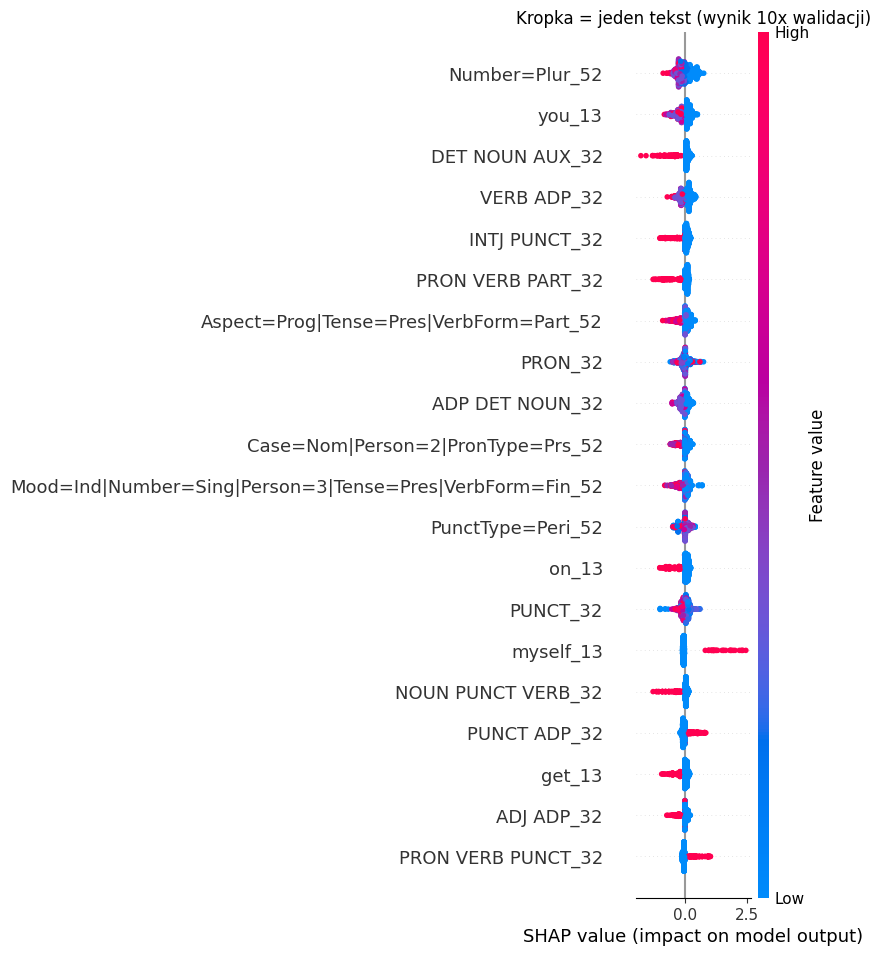

In [53]:
exp.plot_summary()

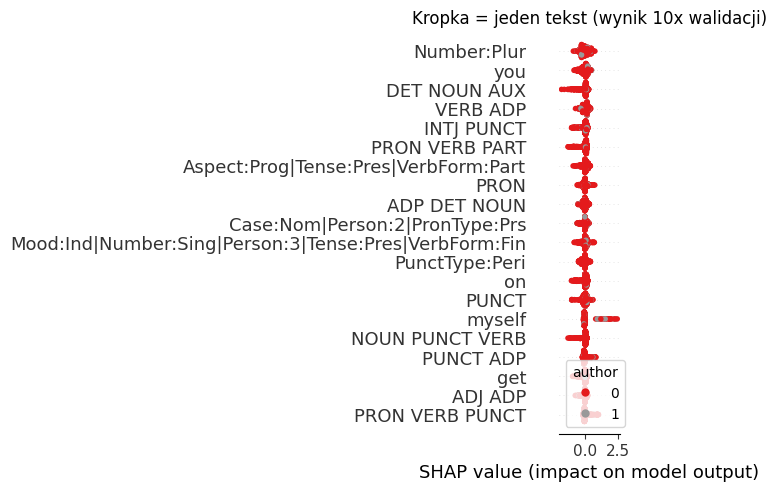

In [56]:
exp.plot_group_summary('author')

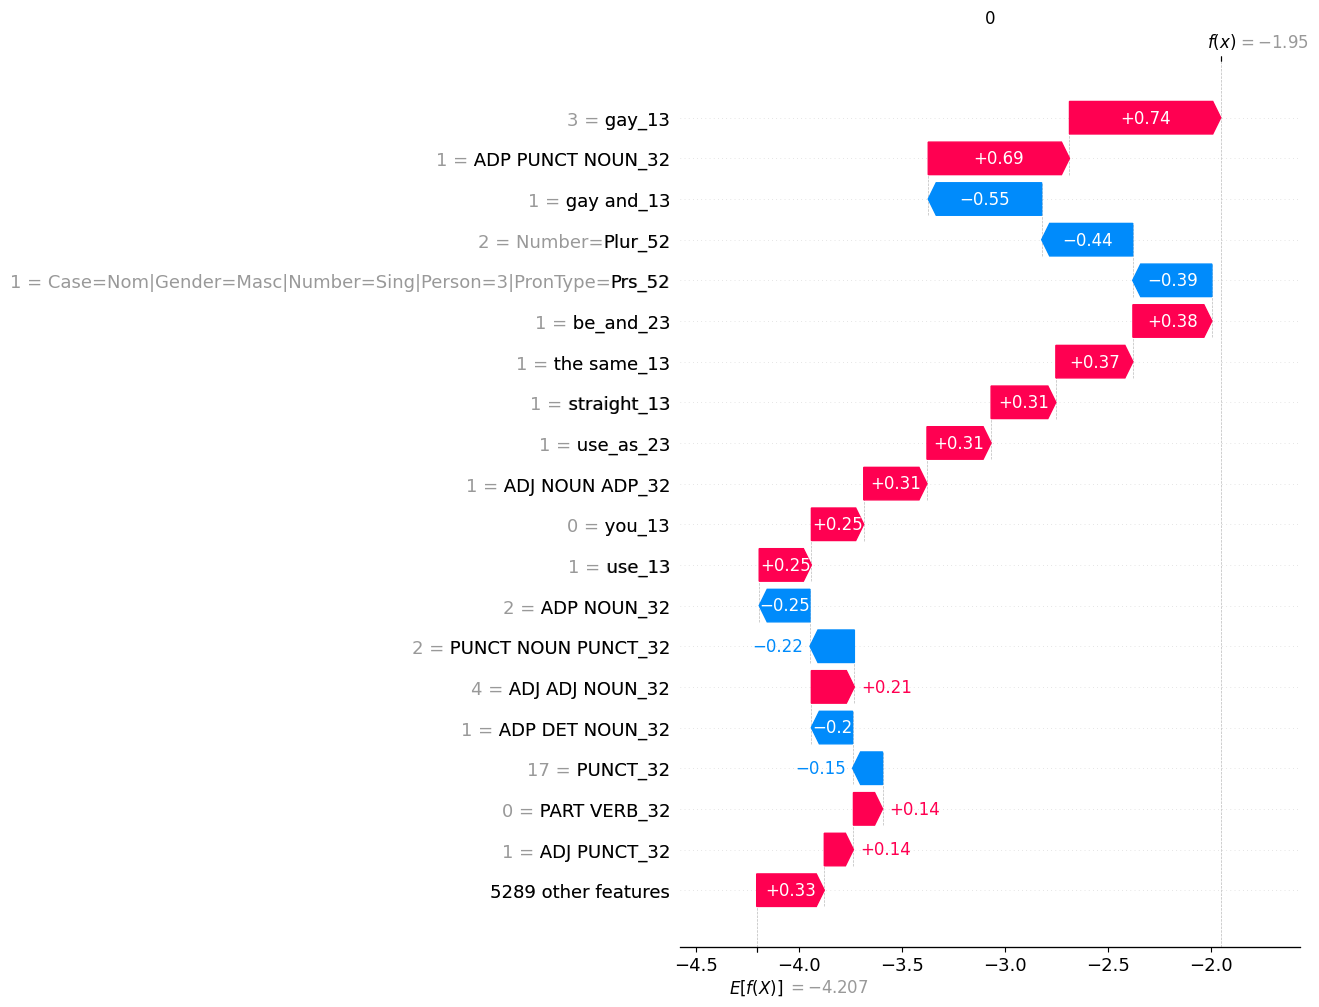

In [55]:
exp.plot_text(8)

In [ ]:
# exp.plot_group_texts('class',group='dukaj') # not working at the moment

Finally, if you would like to see these features highlighted in a given text, set the `index` of the sample that you want to look at, and limit the number of features shown.

Run the cells below.

In [ ]:
index = 8
feat_num = 10

In [ ]:
import re
import numpy as np
from cl_explainable_stylo import feature_extraction, shared_module, text_visualise

df_wiz = pd.DataFrame({'shap': exp.explanations.shap_average[index],'freq':exp.explanations.shap_cv[index][0].data,'feature_names':exp.feature_names,
                       'lextypes': [int(re.search(r"_\d{2}$", f).group()[1:]) for f in exp.feature_names],# [int(f.split('_')[-1]) for f in feature_names]
                       'feature_types':[feature_extraction.dic_to_lextypes[int(re.search(r"_\d{2}$", f).group()[1:])] for f in exp.feature_names]})# ZAKŁADAJĄC, ŻE MAM 1000 CECH Z KAŻDEGO RODZAJU
df_wiz['shap_pct']=df_wiz['shap'].rank(pct=True).round(2)

# WYBIERZ N NAJMOCNIEJSZYCH CECH
# najwieksze = pd.merge(df_wiz.nlargest(100,'shap').round(decimals=2),
#                      df_wiz.nsmallest(100,'shap').round(decimals=2),how='outer')
# WYBIERZ N NAJMOCNIEJSZYCH CECH DANEGO TEKSTU
feat_largest = np.argsort(-np.abs(exp.explanations.shap_average[index]))[0:feat_num]
najwieksze = df_wiz[df_wiz.feature_names.isin( np.array(exp.feature_names)[feat_largest] )].round(decimals=2)
# WYBIERZ NAJMOCNIEJSZE CECHY WG PERCENTYLI
# gorny_percentyl = 0.99 # features indicating class 0
# dolny_percentyl = 0.01 # features indicating class 1
# najwieksze = pd.merge(df_wiz[df_wiz['shap_pct']>gorny_percentyl].round(decimals=2),
#                      df_wiz[df_wiz['shap_pct']<dolny_percentyl].round(decimals=2),how='outer')
# WYBIERZ POJEDYNCZĄ CECHĘ
# najwieksze  = df_wiz.sort_values('shap',ascending=False).iloc[cecha:cecha+1].round(decimals=2)

najwieksze = najwieksze.reset_index()

# ATTRIBUTES: https://spacy.io/api/matcher#patterns
# Działa dla:
# ['LEMMA','POS','MORPH','LOWER','ORTH','D2-LOWER','D2-LEMMA']
doc = shared_module.nlp(exp.docs_subsampled[index].text)
doc.spans['ALL'] = list()
# for lt in feature_scheme['features']:
#     # print(lt)
#     match_lextype(doc.doc,feature_values=najwieksze,lextype=lt)
#     doc.spans['ALL'].extend(doc.spans[str(lt)])
for i, row in najwieksze.iterrows():
    text_visualise.match_lextype(doc.doc,feature_values=row,lextype=row['lextypes'],option='feature')
    doc.spans['ALL'].extend(doc.spans[row['feature_names'].split('_')[0]])

#     Dodać Span.set_extension z wartością SHAP? Można związać z tym jakiś wektor...

import spacy
from spacy import displacy
# https://spacy.io/api/top-level#displacy.render
# https://spacy.io/usage/visualizers
from matplotlib import pyplot as plt
# import matplotlib as mpl
# https://stackoverflow.com/questions/68765137/displacy-custom-colors-for-custom-entities-using-displacy
from matplotlib.colors import to_hex
from matplotlib import colormaps, colorbar

# TO DO: POPRAW ZAKRES WARTOŚCI, PODAJ ETYKIETY KLAS NA GRANICACH
def plot_colormap(pallete,plot = True):
    if plot == True:
        fig, ax = plt.subplots(figsize=(10,0.5))
        col_map = plt.get_cmap(pallete)
        colorbar.ColorbarBase(ax, cmap=col_map, orientation = 'horizontal')
        return plt.show(fig)
    else:
        return None

def choose_color(option,features):
    colors = {}
    if option == 'shap':
        # POKOLORUJ WEDŁUG PERCENTYLI
        # pallete = shap.plots.colors.red_blue # używana w SHAP beeswarm plot
        pallete = 'PiYG' # zielone: SHAP>0, fuksja: SHAP<0, jasne: bliskie zera
        plot_colormap(pallete,plot = True)

        for sh in features['shap'].unique():
            c = features[features['shap']==sh]['shap_pct'].mean()
            for _, row in features[features['shap']==sh].iterrows():
                colors[str(row['lextypes'])+'-'+feature_extraction.dic_to_lextypes[row['lextypes']]+' '+str(sh)] = to_hex(colormaps[pallete](c))
    elif option == 'feature_types':
        # POKOLORUJ WEDŁUG TYPU CECHY
        pallete = 'Set3'#'tab10'
        plot_colormap(pallete,plot = False)
        # for lt in ['LEMMA','POS','MORPH','LOWER','D2-LOWER','D2-LEMMA']:
        for i, lt in enumerate(features['lextypes']):
            for _, row in features[features['lextypes']==lt].iterrows():
                colors[str(row['lextypes'])+'-'+feature_extraction.dic_to_lextypes[row['lextypes']]+' '+str(row['shap'])] = to_hex(colormaps[pallete](i))
    elif option == 'feature_names':
        # POKOLORUJ WEDŁUG NAZWY CECHY
        pallete = 'Set3'#'tab10'
        plot_colormap(pallete,plot = False)
        for i, row in features.iterrows():
            colors[row['feature_names'].split('_')[0]+' '+str(row['shap'])] = to_hex(colormaps[pallete](i))
    else:
        print('"option" must be one of: "shap", "feature_types" or "feature_names".')
        return
    return colors

html = displacy.render(doc, style="span",options= {"spans_key":'ALL','colors':choose_color(option = 'feature_names',features = najwieksze)},page=True,jupyter = True)

## 🧪 Your Playground

You can now run your own analyses using functions from `cl_explainable_stylo`, loading texts and experimenting with stylistic explainability.